# Heart-Disease Classification
Split → impute → scale → tune → evaluate (ROC-AUC + 90 % recall)

In [4]:
# ---------- 1. Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, recall_score, precision_score,
                             RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from scipy.stats import randint, uniform

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
# ---------- 2. Load data ----------
df = pd.read_csv('/content/drive/MyDrive/01_Heart_Disease_Prediction/data/heart_disease_classification_dataset.csv')
df = df.drop(columns=['Unnamed: 0'])

# Encode categoricals
df['sex']     = df['sex'].map({'female': 0, 'male': 1})
df['target']  = df['target'].map({'no': 0, 'yes': 1})

# Create X and y
X = df.drop('target', axis=1)
y = df['target']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# ---------- 3. Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### 🔧 Helper: `make_pipe` – turn any estimator into a full ML pipeline

`make_pipe` is a tiny factory that wraps any scikit-learn estimator (classifier or regressor) into a **re-usable, 3-step pipeline**:

1. **Impute missing values**  
   `SimpleImputer(strategy='median')` replaces every missing entry in each numeric column with the **median** of that column.  
   - Fast, robust to outliers, needs no target variable.  
   - Works on both training and future data in the exact same way.

2. **Standardize features**  
   `StandardScaler()` subtracts the mean and divides by the standard deviation for every feature.  
   - Centers the data at zero and gives it unit variance.  
   - Critical for algorithms that rely on distance or gradient descent (SVM, logistic regression, neural nets, etc.).

3. **Attach your estimator**  
   The supplied `estimator` (e.g. `RandomForestClassifier()`, `LogisticRegression()`, `XGBRegressor()`, …) receives the clean, imputed, scaled data and learns the final model.


In [8]:
# ---------- 4. Helper: build pipeline ----------
def make_pipe(estimator):
    return Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale',  StandardScaler()),
        ('clf',    estimator)
    ])

### 📦 Model Zoo – ready-to-train configurations for 5 algorithms

The dictionary `models` packages every candidate into two consistent keys:  
1. `pipe` – a **pre-processing + estimator** stack built by `make_pipe`.  
2. `search` – the **hyper-parameter sampling space** for `RandomizedSearchCV`.  
   If `search` is `None`, the model is already self-tuning.

| key  | estimator in `pipe` | highlights | hyper-parameter distributions (`search`) |
|---|---|---|---|
| **logit** | `LogisticRegressionCV` | Auto-tunes `C` via 5-fold CV on ROC-AUC; `class_weight='balanced'` handles imbalance. | none – already tuned |
| **rf** | `RandomForestClassifier` | Bagged trees; robust default learner. | `#trees`, `max_depth`, `min_samples_split`, `max_features` |
| **gb** | `GradientBoostingClassifier` | Sequential boosting; good baseline before XGBoost. | `#trees`, `learning_rate`, `max_depth` |
| **svm** | `SVC` | Large-margin + RBF; probabilities enabled for ROC. | `C`, `gamma`, `kernel` |
| **knn** | `KNeighborsClassifier` | Instance-based baseline. | `#neighbors`, `weights`, `p` |
| **xgb** | `XGBClassifier` | High-performance gradient boosting; native regularisation, subsampling, early-stopping-ready. | `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `min_child_weight`, `reg_alpha`, `reg_lambda` |

In [9]:
# ---------- 5. Model configs ----------
models = {
    'logit': {
        'pipe': make_pipe(LogisticRegressionCV(
            Cs=10, cv=5, scoring='roc_auc', max_iter=1000,
            class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)),
        'search': None
    },
    'rf': {
        'pipe': make_pipe(RandomForestClassifier(
            class_weight='balanced', random_state=RANDOM_STATE)),
        'search': {
            'clf__n_estimators': randint(100, 800),
            'clf__max_depth':    randint(3, 12),
            'clf__min_samples_split': randint(2, 20),
            'clf__max_features': ['sqrt', 'log2', 0.5]
        }
    },
    'gb': {
        'pipe': make_pipe(GradientBoostingClassifier(random_state=RANDOM_STATE)),
        'search': {
            'clf__n_estimators':  randint(50, 400),
            'clf__learning_rate': uniform(0.01, 0.3),
            'clf__max_depth':     randint(2, 8)
        }
    },
    'svm': {
        'pipe': make_pipe(SVC(class_weight='balanced', probability=True,
                              random_state=RANDOM_STATE)),
        'search': {
            'clf__C':      uniform(0.1, 100),
            'clf__gamma':  uniform(0.001, 1),
            'clf__kernel': ['rbf', 'linear']
        }
    },
    'knn': {
        'pipe': make_pipe(KNeighborsClassifier()),
        'search': {
            'clf__n_neighbors': randint(3, 30),
            'clf__weights':     ['uniform', 'distance'],
            'clf__p':           [1, 2]
        }
    },
    'xgb': {
        'pipe': make_pipe(XGBClassifier(
          objective='binary:logistic',
          eval_metric='auc',
          n_jobs=-1,
          random_state=RANDOM_STATE)),
    'search': {
        'clf__n_estimators':     randint(100, 1000),
        'clf__max_depth':        randint(3, 12),
        'clf__learning_rate':    uniform(0.01, 0.3),
        'clf__subsample':        uniform(0.6, 0.4),  # 0.6–1.0
        'clf__colsample_bytree': uniform(0.6, 0.4),
        'clf__gamma':            uniform(0, 5),
        'clf__min_child_weight': randint(1, 10),
        'clf__reg_alpha':        uniform(0, 1),
        'clf__reg_lambda':       uniform(0, 2)
    }
  }
}

In [10]:
# ---------- 6. Train & tune ----------
results = {}

for name, cfg in models.items():
    print(f"\n>>> Tuning {name} ...")
    if cfg['search'] is None:  # Logit
        model = cfg['pipe']
        model.fit(X_train, y_train)
        best_est = model
        cv_score = model.named_steps['clf'].scores_[1].mean()
    else:
        search = RandomizedSearchCV(
            cfg['pipe'], cfg['search'],
            n_iter=40, cv=5, scoring='roc_auc',
            n_jobs=-1, random_state=RANDOM_STATE)
        search.fit(X_train, y_train)
        best_est = search.best_estimator_
        cv_score = search.best_score_

    y_prob = best_est.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob)

    # threshold for 90 % recall
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    idx = np.argmax(recalls >= 0.90)
    thresh = thresholds[idx] if idx < len(thresholds) else 0.5
    y_pred = (y_prob >= thresh).astype(int)
    recall = recall_score(y_test, y_pred)

    results[name] = {
        'cv_auc': cv_score,
        'test_auc': test_auc,
        'threshold': thresh,
        'recall@90': recall,
        'estimator': best_est
    }
    print(f"{name} — CV AUC: {cv_score:.3f}  Test AUC: {test_auc:.3f}  Recall@90: {recall:.3f}")


>>> Tuning logit ...
logit — CV AUC: 0.899  Test AUC: 0.883  Recall@90: 1.000

>>> Tuning rf ...
rf — CV AUC: 0.917  Test AUC: 0.908  Recall@90: 1.000

>>> Tuning gb ...
gb — CV AUC: 0.907  Test AUC: 0.899  Recall@90: 1.000

>>> Tuning svm ...
svm — CV AUC: 0.911  Test AUC: 0.876  Recall@90: 1.000

>>> Tuning knn ...
knn — CV AUC: 0.914  Test AUC: 0.935  Recall@90: 1.000

>>> Tuning xgb ...
xgb — CV AUC: 0.920  Test AUC: 0.880  Recall@90: 1.000


In [11]:
# ---------- 7. Summary ----------
summary = pd.DataFrame({k: [results[k]['cv_auc'],
                            results[k]['test_auc'],
                            results[k]['recall@90']] for k in results},
                       index=['CV AUC', 'Test AUC', 'Recall@90']).T
summary.sort_values('Test AUC', ascending=False)

,CV AUC,Test AUC,Recall@90
knn,0.914213,0.934524,1.0
rf,0.917301,0.908009,1.0
gb,0.906566,0.899351,1.0
logit,0.899257,0.883117,1.0
xgb,0.919801,0.879870,1.0
svm,0.910632,0.875541,1.0


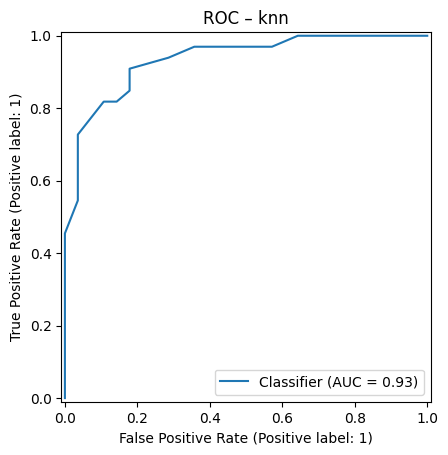

In [12]:
# ---------- 8. ROC curve ----------
best_name = summary.idxmax()['Test AUC']
best_model = results[best_name]['estimator']
y_prob_best = best_model.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_prob_best)
plt.title(f'ROC – {best_name}')
plt.show()

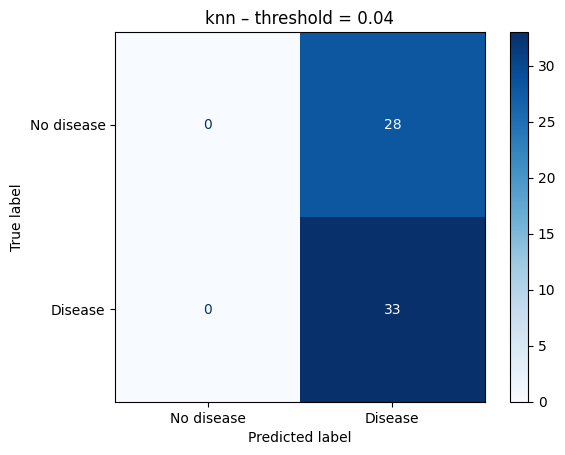

In [13]:
# ---------- 9. Confusion matrix ----------
thresh = results[best_name]['threshold']
y_pred_best = (y_prob_best >= thresh).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No disease', 'Disease'])
disp.plot(cmap='Blues')
plt.title(f'{best_name} – threshold = {thresh:.2f}')
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'clf__colsample_bytree': np.float64(0.7465447373174767), 'clf__gamma': np.float64(2.28034992108518), 'clf__learning_rate': np.float64(0.24555278841790407), 'clf__max_depth': 5, 'clf__min_child_weight': 7, 'clf__n_estimators': 343, 'clf__reg_alpha': np.float64(0.5924145688620425), 'clf__reg_lambda': np.float64(0.09290082543999545), 'clf__subsample': np.float64(0.8430179407605753)}
XGB  test AUC: 0.8799


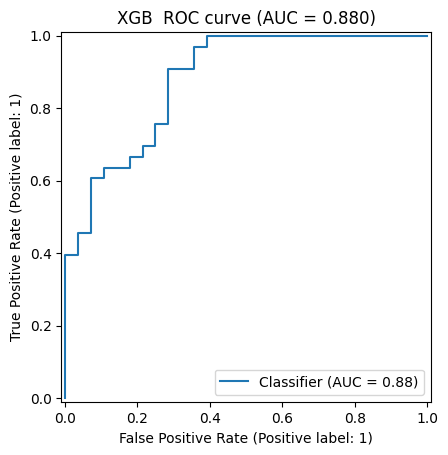

In [14]:
# ---------- 6. Fit & evaluate ----------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# pick an algorithm from the zoo
name = 'xgb'
pipe  = models[name]['pipe']
space = models[name]['search']

# 1. Hyper-parameter search (skip if search is None)
if space is None:          # e.g. LogisticRegressionCV
    best_model = pipe.fit(X_train, y_train)
else:
    rs = RandomizedSearchCV(
            pipe, space,
            n_iter=50,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    print(f"Best params: {rs.best_params_}")

# 2. Hold-out test score
y_prob = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)
print(f"{name.upper()}  test AUC: {test_auc:.4f}")

# 3. Quick ROC plot
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"{name.upper()}  ROC curve (AUC = {test_auc:.3f})")
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'clf__n_neighbors': 27, 'clf__p': 1, 'clf__weights': 'uniform'}
KNN  test AUC: 0.9345


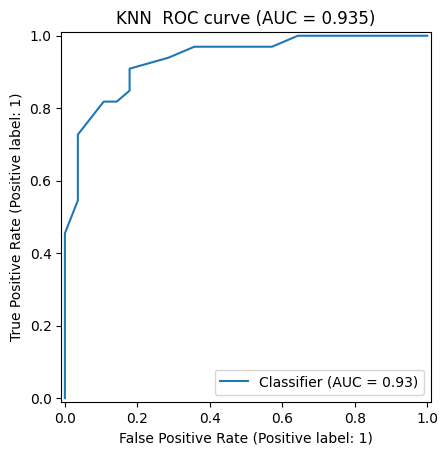

In [15]:
# ---------- 6. Fit & evaluate ----------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# pick an algorithm from the zoo
name = 'knn'
pipe  = models[name]['pipe']
space = models[name]['search']

# 1. Hyper-parameter search (skip if search is None)
if space is None:          # e.g. LogisticRegressionCV
    best_model = pipe.fit(X_train, y_train)
else:
    rs = RandomizedSearchCV(
            pipe, space,
            n_iter=50,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    print(f"Best params: {rs.best_params_}")

# 2. Hold-out test score
y_prob = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)
print(f"{name.upper()}  test AUC: {test_auc:.4f}")

# 3. Quick ROC plot
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"{name.upper()}  ROC curve (AUC = {test_auc:.3f})")
plt.show()